In [52]:
# Load dependencies
include("Graph.jl")
include("DataModule.jl")
include("UtilsModule.jl")
include("AccuracyModule.jl")
include("GradientOptimizersModule.jl")

using .DataModule, .UtilsModule, .AccuracyModule, .GradientOptimizersModule
using Random, Plots

In [53]:
# Util functions
function load_data(batch_size)
    println("Loading train data...")
    train_x, train_y = DataModule.preprocess(:train; one_hot = true)

    train_x_batched = DataModule.batch(train_x, batch_size)
    train_y_batched = DataModule.batch(train_y, batch_size)

    println("Loading test data...")
    test_x, test_y = DataModule.preprocess(:test; one_hot = true)
    return train_x, train_y, train_x_batched, train_y_batched, test_x, test_y
end

function update_weights!(graph::Vector, optimizer::GradientOptimizersModule.GradientOptimizer)
    for node in graph
        if isa(node, Variable)
            if node.gradient != nothing
                node.output .-= optimizer(node.gradient)
                node.gradient .= 0
            elseif node.gradient == nothing
                node.output = nothing
            end
        end
    end
end


update_weights! (generic function with 6 methods)

In [54]:
function train(batch_size, epochs, optimizer)
    train_x, train_y, train_x_batched, train_y_batched, test_x, test_y = load_data(batch_size)

    x = Variable([0.], name="x")

    wd = Variable(UtilsModule.glorot_uniform(10, 64))
    bd = Variable(UtilsModule.glorot_uniform(10, ))
    fd = Constant(UtilsModule.identity)
    dfd = Constant(UtilsModule.identity_deriv)

    wr = Variable(UtilsModule.glorot_uniform(64, 196))
    br = Variable(UtilsModule.glorot_uniform(64, ))
    hwr = Variable(UtilsModule.glorot_uniform(64, 64))
    states = Variable(nothing, name = "states")
    fr = Constant(tanh)
    dfr = Constant(UtilsModule.tanh_deriv)

    optimizer = GradientOptimizersModule.Descent(15e-3)

    r = rnn_layer(x, wr, br, hwr, states, fr, dfr)
    d = dense_layer(r, wd, bd, fd, dfd)
    graph = topological_sort(d)


    batch_loss = Float64[]
    batch_acc = Float64[]
    println("Training")
    for epoch in 1:epochs
        batches = randperm(size(train_x_batched, 1))
        @time for batch in batches
            states.output = nothing
            x.output = train_x_batched[batch][  1:196,:]
            forward!(graph)

            x.output = train_x_batched[batch][197:392,:]
            forward!(graph)

            x.output = train_x_batched[batch][393:588,:]
            forward!(graph)

            x.output = train_x_batched[batch][589:end,:]
            result = forward!(graph)

            loss = AccuracyModule.loss(result, train_y_batched[batch])
            acc = AccuracyModule.accuracy(result, train_y_batched[batch])
            push!(batch_loss, loss)
            push!(batch_acc, acc)
            
            gradient = AccuracyModule.gradient(result, train_y_batched[batch]) ./ batch_size
            backward!(graph, seed=gradient)
            update_weights!(graph, optimizer)
        end
        states.output = nothing
        test_graph = topological_sort(d)

        x.output = test_x[  1:196,:]
        forward!(test_graph)

        x.output = test_x[197:392,:]
        forward!(test_graph)

        x.output = test_x[393:588,:]
        forward!(test_graph)

        x.output = test_x[589:end,:]
        result = forward!(test_graph)

        loss = AccuracyModule.loss(result, test_y)
        acc = AccuracyModule.accuracy(result, test_y)

        @show epoch loss acc
    end
    return batch_loss, batch_acc
end

train (generic function with 2 methods)

In [63]:
batch_loss, batch_acc = train(100, 5, GradientOptimizersModule.Descent(15e-3))

Loading train data...
Loading test data...
Training
  3.154417 seconds (226.81 k allocations: 1.176 GiB, 15.77% gc time)
epoch = 1
loss = 1.061741f0
acc = 71.25
  2.870897 seconds (226.80 k allocations: 1.176 GiB, 3.01% gc time)
epoch = 2
loss = 0.76087356f0
acc = 79.54
  2.512542 seconds (226.80 k allocations: 1.176 GiB, 2.73% gc time)
epoch = 3
loss = 0.6158427f0
acc = 83.01
  2.521295 seconds (226.80 k allocations: 1.176 GiB, 2.31% gc time)
epoch = 4
loss = 0.53118855f0
acc = 85.46
  2.759680 seconds (226.80 k allocations: 1.176 GiB, 2.18% gc time)
epoch = 5
loss = 0.4808749f0
acc = 86.58


([2.536562442779541, 2.296964645385742, 2.534191608428955, 2.535214424133301, 2.343426465988159, 2.3983511924743652, 2.392712354660034, 2.4940054416656494, 2.3887815475463867, 2.4649569988250732  …  0.4414972960948944, 0.4478691816329956, 0.5494570136070251, 0.6044157147407532, 0.5009548664093018, 0.5039759278297424, 0.47170984745025635, 0.47981858253479004, 0.5150401592254639, 0.5030534267425537], [12.0, 20.0, 11.0, 9.0, 21.0, 13.0, 14.0, 11.0, 9.0, 13.0  …  87.0, 86.0, 88.0, 82.0, 89.0, 86.0, 90.0, 87.0, 86.0, 86.0])

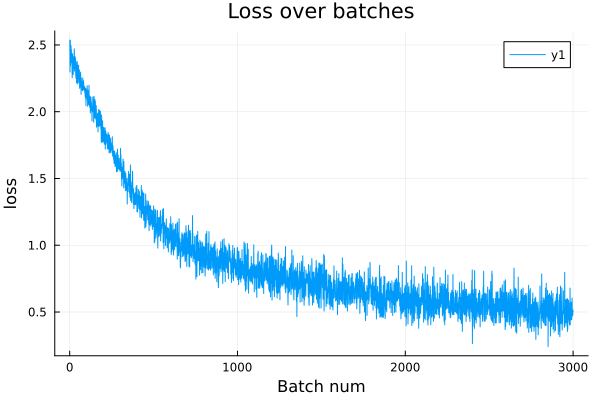

In [64]:
plot(batch_loss, xlabel="Batch num", ylabel="loss", title="Loss over batches")

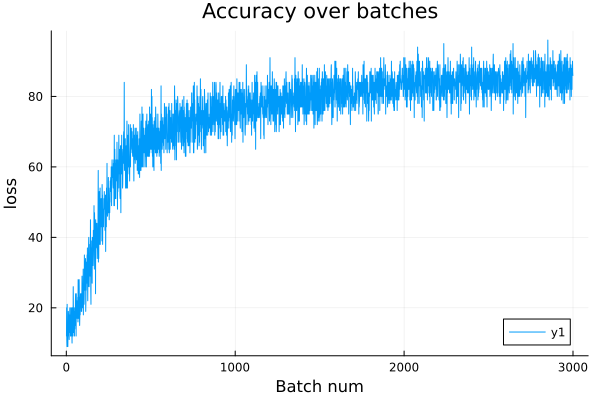

In [65]:
plot(batch_acc, xlabel="Batch num", ylabel="loss", title="Accuracy over batches")